## 1. Manipulação dos dados e feature engineering

Inicilmente, vou importar a maior parte ds bibliotecas que vamos utilizar. As linhas comentadas são as bibliotecas que eu utilizei durnte os testes, mas não no modelo final.

In [1]:
from numpy.random import seed
seed(1)
import os
#from sklearn.model_selection import StratifiedKFold
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, auc, roc_curve, roc_auc_score, precision_recall_curve
#from sklearn.utils import class_weight
#from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit
import pickle

Posteriormente, vou importar os dados de treinamento e adicionar uma nova variável chamada `dias_ate_vencimento`, uma vez que as datas de vencimento e dia atuais se tornam complexas de se trabalhar como input dos modelos. Perceb que há existe uma linha comentada: durante os testes, alguns dos modelos (em especial durante os testes de tunagem de hiperparâmetros), são extremamente pesados. Em alguns casos, como no XGBoost, eu utilizei o Dask. Porém, em outros casos, eu simplesmente utilizei uma amostragem dos dados finais. Essa amostra possui o mesmo desbalanceamento dos dados originais: 92.59% de pagadores e 7,4% de não-pagadores.

In [78]:
train = pd.read_parquet('dados_case_ds1/train.parquet', engine='pyarrow')
train['dias_ate_vencimento'] = (train['vencimento'] - train['dia']).dt.days
train = train.drop(['desembolso','vencimento','dia','id'],axis=1)
#train = train.sample(500000)
dataframe = train.copy()
train.head()

,valor_emprestado,pgto_diario_esperado,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y,dias_ate_vencimento
3281,7100.0,33.7107,0.0,7197.98,7100.0,0.00,0.0,664.0,None,0.0,276
3282,7100.0,33.8852,1.0,7212.25,7100.0,0.00,0.0,0.0,None,0.0,275
3283,7100.0,33.8852,2.0,7226.54,7100.0,0.00,0.0,150.0,None,0.0,274
3284,7100.0,33.8852,3.0,7207.22,7100.0,33.64,0.0,0.0,None,0.0,273
3285,7100.0,33.8852,4.0,7221.51,7100.0,0.00,0.0,0.0,None,0.0,272


In [34]:
test = pd.read_parquet('dados_case_ds1/test.parquet', engine='pyarrow')
test['dias_ate_vencimento'] = (test['vencimento'] - test['dia']).dt.days
test = test.drop(['desembolso','vencimento','dia','id'],axis=1)
test.head()

,valor_emprestado,pgto_diario_esperado,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,dias_ate_vencimento
3554,4600.0,19.3005,0.0,4663.48,4600.0,0.00,0.0,0.0,Calçados,276
3555,4600.0,19.4053,1.0,4668.25,4600.0,0.00,0.0,0.0,Calçados,275
3556,4600.0,19.4053,2.0,4673.03,4600.0,0.00,0.0,320.0,Calçados,274
3557,4600.0,19.4053,3.0,4615.13,4600.0,62.68,0.0,100.0,Calçados,273
3558,4600.0,19.4053,4.0,4619.86,4600.0,0.00,0.0,226.8,Calçados,272


Vamos ter que lidar com o fato de termos menos subsegmentos no conjunto de teste do que no conjunto de treinamento.

In [35]:
test['subsegmento'].nunique()

71

In [36]:
train['subsegmento'].nunique()

73

Vou transformar a feature `subsegmento` em uma variável dummy, uma vez que temos diversas categorias. 

In [37]:
train = pd.get_dummies(train, columns=['subsegmento'], drop_first=True)
test = pd.get_dummies(test, columns=['subsegmento'], drop_first=True)

In [38]:
train.shape

(2889113, 82)

Vou fazer a separação entre X e target. Perceba que duas células abaixo, eu havia feito uma separação e criado um set de treinamento do banco de dados de treino. Isso foi útil para evitar overfit durante o processo de treinamento e checar se as métricas de performance estavam adequadas.

In [39]:
y_train = train['y']
X_train = train.drop(['y'],axis=1)

In [6]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

Checando o quão desbalanceado é nosso banco de dados de forma normalizada (ou seja, em termos percentuais):

In [9]:
print(y_train.value_counts(normalize=True, dropna=False))
print(y_train.shape)

0.0    0.925898
1.0    0.074102
Name: y, dtype: float64
(2889113,)


Checando de test possui alguma categoria a mais que o treinamento:

In [32]:
fieldst = test.columns
fields = X_train.columns
#Colunas que existem no test e não existem no X_train
list(set(fieldst) - set(fields))

['subsegmento_Outras Clínicas',
 'subsegmento_Autopeças e Serviços Automotivos - Outros',
 'subsegmento_Esporte e Fitness - Outros']

In [31]:
#Colunas que existem no X_train e não existem no test
list(set(fields) - set(fieldst))

['subsegmento_Segurança',
 'subsegmento_Artigos Religiosos e Antiguidades',
 'subsegmento_Cias Aéreas',
 'subsegmento_Casa e Decoração - Outros',
 'subsegmento_Paisagismo e Jardinagem']

Parece que sim. Desta forma, vou ter que adicionar variáveis para considerar também este caso. Vou adicionar essas novas features manualmente, porém não irei adicionar novos dados sintéticos (deixaremos isso para os testes com SMOTE, posteriormente).

In [40]:
X_train['subsegmento_Outras Clínicas'] = 0
X_train['subsegmento_Autopeças e Serviços Automotivos - Outros'] = 0
X_train['subsegmento_Esporte e Fitness - Outros'] = 0
test['subsegmento_Segurança'] = 0
test['subsegmento_Artigos Religiosos e Antiguidades'] = 0
test['subsegmento_Cias Aéreas'] = 0
test['subsegmento_Casa e Decoração - Outros'] = 0
test['subsegmento_Paisagismo e Jardinagem'] = 0

In [41]:
X_train.shape

(2889113, 84)

In [42]:
test.shape

(1226415, 84)

## 2. Visualização dos dados

In [75]:
train.describe()

,valor_emprestado,pgto_diario_esperado,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,y,dias_ate_vencimento,...,subsegmento_Serviços Financeiros,subsegmento_Serviços Imobiliários,subsegmento_Softwares e Eletrônica Integrada,subsegmento_Supermercados,subsegmento_Tabacaria,subsegmento_Telecomunicações,subsegmento_Táxi/Carona,subsegmento_Vestuário,subsegmento_Veterinários,subsegmento_Óticas e Óculos
count,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,...,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06,2.889113e+06
mean,1.316104e+04,5.421204e+01,1.021915e+02,8.167070e+03,7.945753e+03,7.140171e+01,5.897608e+01,5.693074e+02,7.410198e-02,2.313129e+02,...,1.259902e-04,3.229365e-04,3.544340e-03,1.801314e-02,1.069186e-03,4.469538e-03,2.710174e-04,4.276537e-02,8.473189e-04,9.160251e-03
std,1.557298e+04,6.012586e+01,7.258616e+01,1.202128e+04,1.164722e+04,2.822804e+02,2.719035e+02,1.426674e+03,2.619368e-01,1.190467e+02,...,1.122383e-02,1.796753e-02,5.942878e-02,1.329988e-01,3.268093e-02,6.670504e-02,1.646038e-02,2.023277e-01,2.909641e-02,9.526985e-02
min,1.000100e+02,2.759000e-01,0.000000e+00,1.010000e+00,-3.695580e+01,-7.279580e+03,-7.273392e+03,-1.000000e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.600000e+03,1.563170e+01,4.200000e+01,1.469280e+03,1.436800e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.900000e+03,3.395960e+01,8.900000e+01,4.017630e+03,3.922101e+03,0.000000e+00,0.000000e+00,1.084000e+02,0.000000e+00,2.210000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.612000e+04,6.882470e+01,1.510000e+02,9.764290e+03,9.489511e+03,5.781000e+01,3.824060e+01,6.035600e+02,0.000000e+00,3.010000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.129920e+05,5.913233e+02,3.610000e+02,2.130434e+05,2.129920e+05,1.210000e+05,1.202322e+05,1.785886e+05,1.000000e+00,6.380000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [87]:
dataframe.isnull().sum()

valor_emprestado                      0
pgto_diario_esperado                  0
dias_pos_desembolso                   0
divida_total                          0
divida_principal                      0
pagamento_diario                      0
amortizacao_principal_diario          0
transacionado                         0
subsegmento                     1525160
y                                     0
dias_ate_vencimento                   0
dtype: int64

Checando a quantidade de não-pagadores por subsegmento. Percebe-se que alguns sebsegmentos possuem um percentual maior de não-pagadores. Entre eles: vestuário, ótimas e entretenimento.

<AxesSubplot:title={'center':'Fraude'}, xlabel='count', ylabel='subsegmento'>

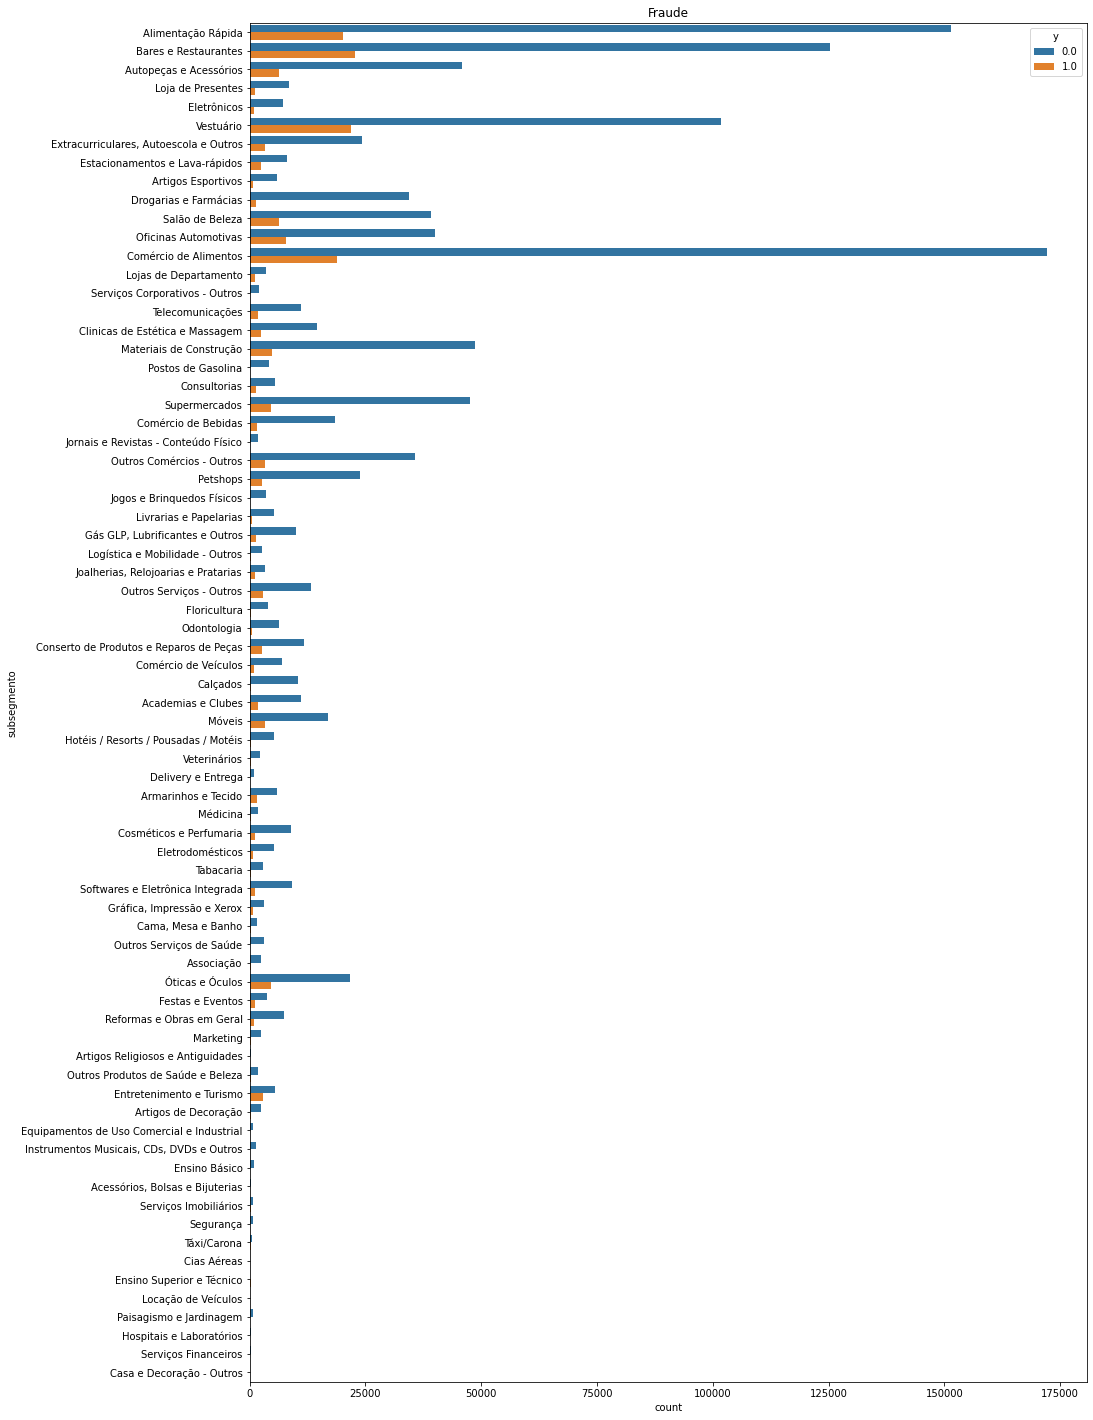

In [79]:
plt.figure(figsize=(15,25))
#plt.grid()
plt.title('Fraude')
sns.countplot(y="subsegmento", hue="y", data=dataframe)

Também podemos analisar estatísticamente os subsegmentos olhando boxplots. Percebe-se que existem alguns outliers em supermercados, alimentação rápida, vestuário e alimentos. Da mesma forma, alguns subsegmentos, como equipamentos possuem um range gigantesco de valor total do empréstimo.

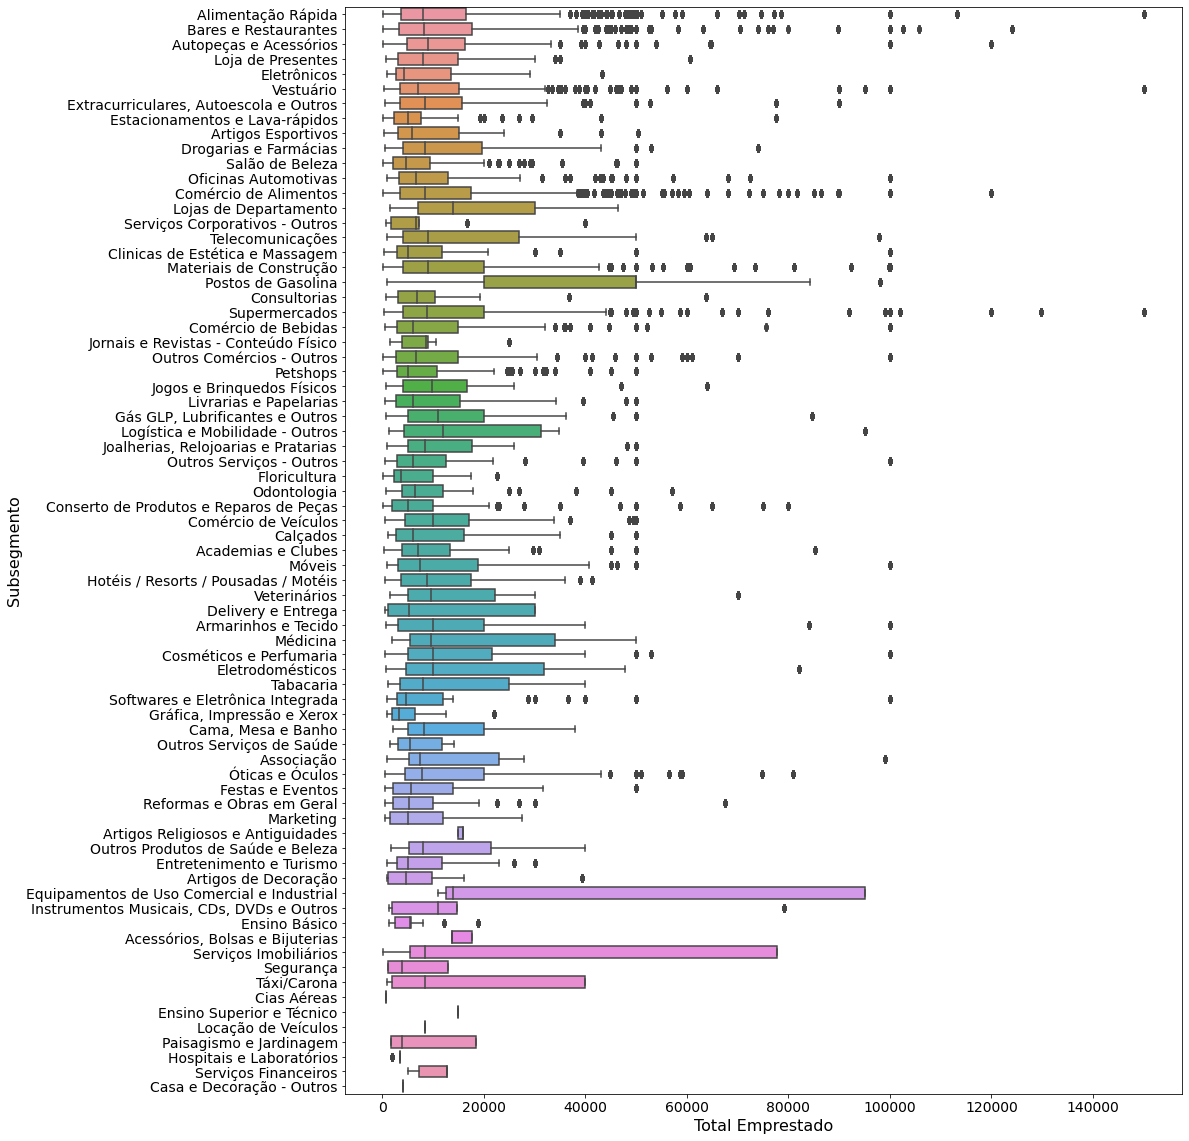

In [85]:
import seaborn as sns
plt.figure(figsize=(15,20))
sns.boxplot(y='subsegmento', x='valor_emprestado', data=dataframe,orient='h')
plt.xlabel("Total Emprestado", fontsize=16)
plt.ylabel("Subsegmento", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [80]:
def plot_var(col_name, variavel,dataset):
    fig, [[ax1, ax2],[ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), dpi=90)
    sns.distplot(dataset.loc[dataset[col_name].notnull(), col_name], kde=False, ax=ax1)
    log_s = dataframe[col_name].apply(lambda x: np.log(x + 1))
    sns.distplot(log_s , kde=False, ax=ax2)
    sns.boxplot(x=col_name, y='y', data=dataset, ax=ax3,orient='h')
    sns.boxplot(x=log_s, y='y', data=dataset, ax=ax4,orient='h')
    ax1.set_xlabel(variavel)
    ax1.set_ylabel('Frequência')
    ax1.set_title(variavel)
    ax2.set_xlabel(variavel)
    ax2.set_title(variavel + ' após transformada logarítmica')
    ax3.set_xlabel(variavel)
    ax3.set_ylabel('')
    ax3.set_title(variavel + ' por Inadimplência')
    ax4.set_ylabel('')
    ax4.set_xlabel('Log('+variavel+')')
    ax4.set_title(variavel + ' por Inadimplência após transformada')
    fig.tight_layout()

Analisando as variáveis separadamente, observa-se que a maioria tem um desvio significativo à esquerda. Possivelmente, a utilização de scalers ou transformadas logarítmocas pode nos ajudar a ter uma melhoria do modelo.

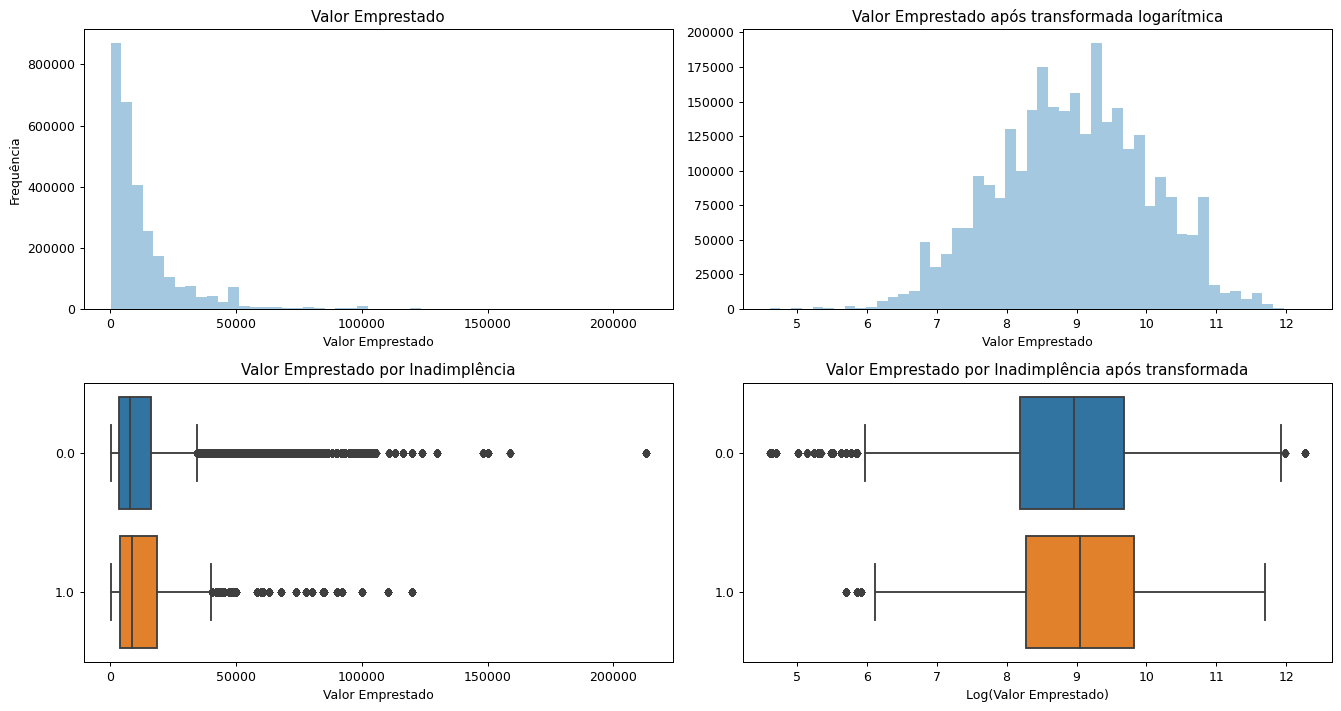

In [81]:
import warnings
warnings.filterwarnings("ignore")
dataframe = train.copy()
plot_var('valor_emprestado','Valor Emprestado',dataframe)

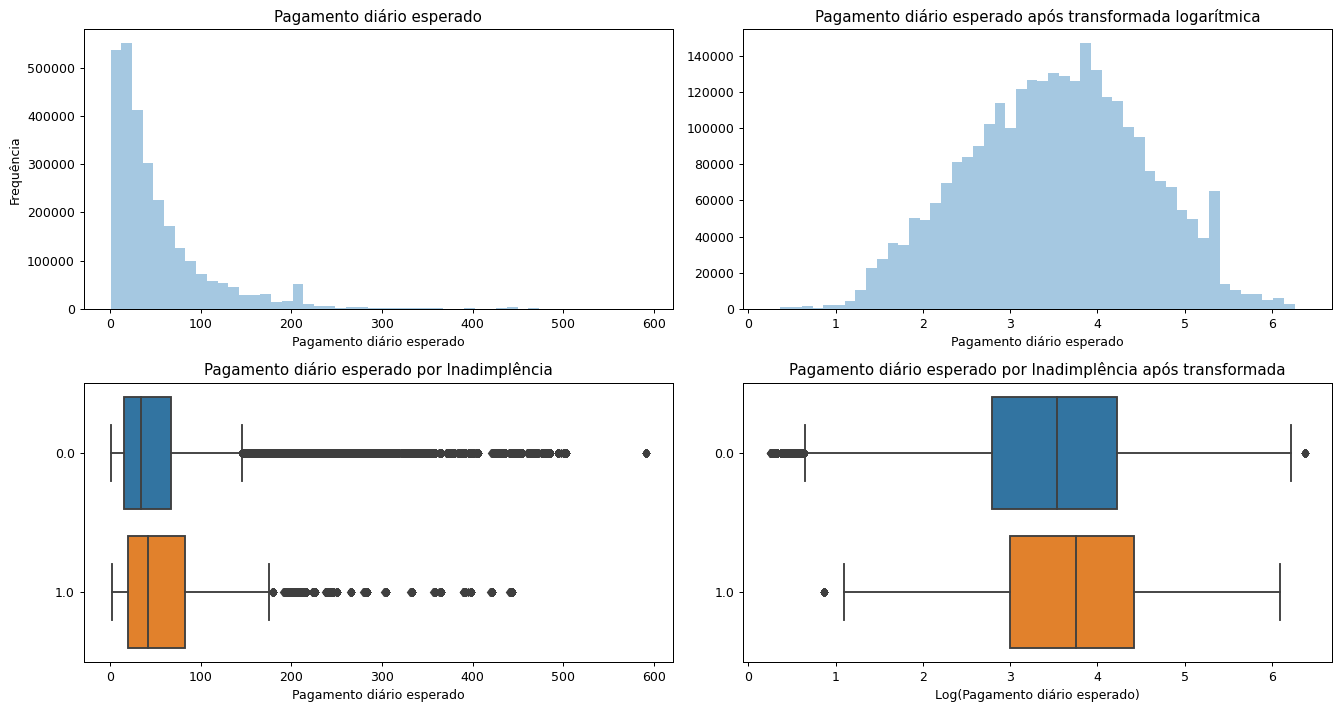

In [70]:
plot_var('pgto_diario_esperado','Pagamento diário esperado',dataframe)

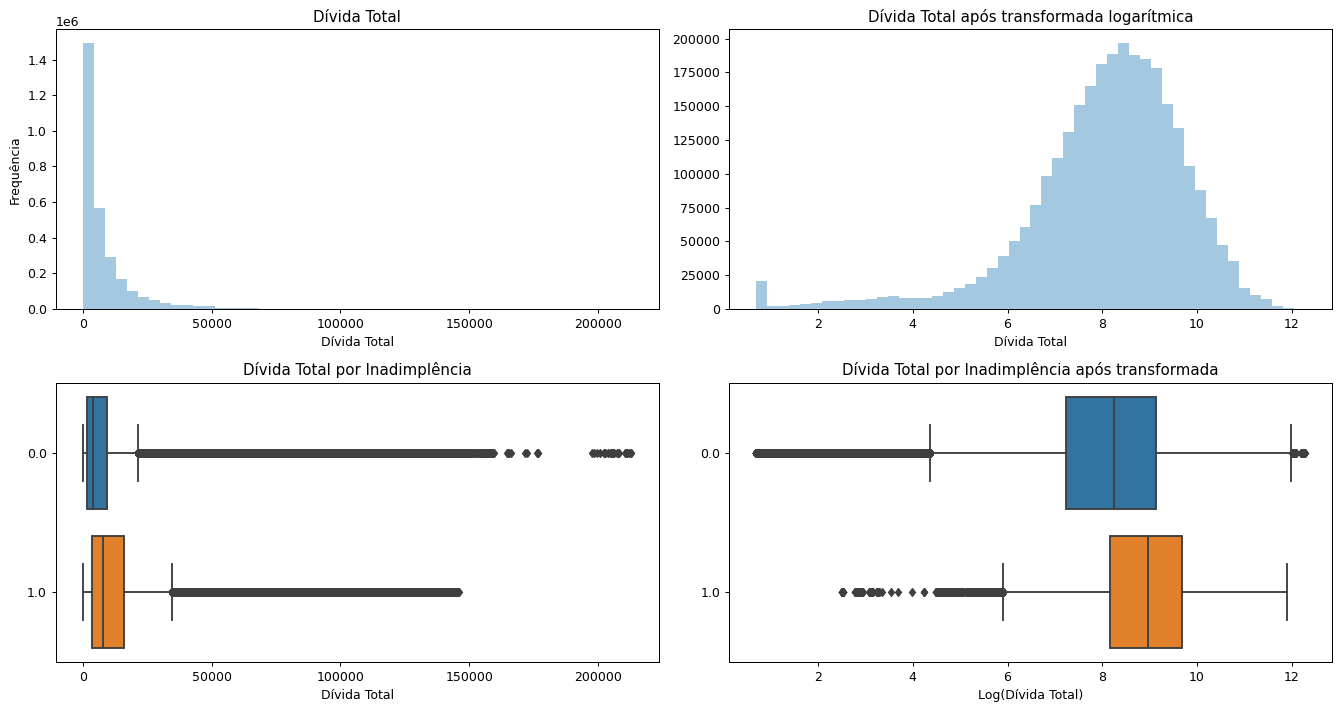

In [71]:
plot_var('divida_total','Dívida Total',dataframe)

## 3. Modelo final

Considerando a diferença de range das variáveis, apliquei um `StandardScaler` para evitar que diferentes pesos sejam dados. O StandardScaler implementa a TransformerAPI para calcular a média e o desvio padrão em um conjunto de treinamento, de modo a poder reaplicar posteriormente a mesma transformação no conjunto de teste.

In [43]:
scl = preprocessing.StandardScaler()
fields = X_train.columns
X_train = pd.DataFrame(scl.fit_transform(X_train), columns = fields)

Rodando o `RandomForestClassifier` como modelo benchmark.

In [44]:
model_xgb = RandomForestClassifier(random_state=42)
eval_set = [(X_train, y_train.values.ravel())]
eval_metric = ['auc', 'error']

model_xgb.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

Agora, vamos analisar as métricas de performance do modelo de treinamento. Percebe-se que temos uma acurácia extremamente alta. Possivelmente, poderíamos ter um problema de overfit, porém, como eu informei anteriormente, eu fiz este teste criando um banco de dados de teste do banco de dados do treinamento. 

In [45]:
# Make predictions and determine the error
y_pred_xgb = model_xgb.predict(X_train)
print("Accuracy: %.2f%%" % (model_xgb.score(X_train, y_train) * 100))
print(confusion_matrix(y_train, y_pred_xgb))
print('F1 Score:', f1_score(y_train, y_pred_xgb))
print(classification_report(y_train, y_pred_xgb))
# predict probabilities
prob = model_xgb.predict_proba(X_train)
# keep probabilities for the positive outcome only
preds = prob[:,1]
# calculate pr curve
precision_xgb, recall_xgb, threshold = precision_recall_curve(y_train, preds)
# calculate auc, equivalent to roc_auc_score()?
print('PR-AUC: ', auc(recall_xgb, precision_xgb))

Accuracy: 100.00%
[[2675015       9]
 [     56  214033]]
F1 Score: 0.9998481773102158
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2675024
         1.0       1.00      1.00      1.00    214089

    accuracy                           1.00   2889113
   macro avg       1.00      1.00      1.00   2889113
weighted avg       1.00      1.00      1.00   2889113

PR-AUC:  0.9999990415144588


In [46]:
filename = 'random_forest.pkl'
pickle.dump(model_xgb, open(filename, 'wb'))

Fazendo a mesma preparação no banco de dados de teste: transformando em dummy e, posteriormente, aplicando o mesmo scaler (atenção à função `transform` e não `fit_transform`).

In [47]:
fieldst = test.columns
test = pd.DataFrame(scl.transform(test), columns = fieldst)

Checando as colunas que não existem no conjunto de teste:

In [48]:
# Make predictions and determine the error
y_pred_xgb = model_xgb.predict(test)
# predict probabilities
prob = model_xgb.predict_proba(test)
# keep probabilities for the positive outcome only
preds = prob[:,1]

Criando o dataframe final com os IDs, predição e probabilidade.

In [57]:
test2 = pd.read_parquet('dados_case_ds1/test.parquet', engine='pyarrow')
submission_s = test2['id']
submission_s

3554            7.0
3555            7.0
3556            7.0
3557            7.0
3558            7.0
             ...   
29333237    59440.0
29333238    59440.0
29333239    59440.0
29333240    59440.0
29333241    59440.0
Name: id, Length: 1226415, dtype: float64

In [60]:
submission = pd.DataFrame(list(zip(submission_s, y_pred_xgb, preds)),
               columns =['id', 'ypred','yprob'])
submission.head()

,id,ypred,yprob
0,7.0,0.0,0.05
1,7.0,0.0,0.05
2,7.0,0.0,0.01
3,7.0,0.0,0.04
4,7.0,0.0,0.01


In [61]:
submission.to_parquet('submission.parquet')

## 4. Explicação dos resultados

Primeiramente, apliquei algumas técnicas para determinar qual o melhore modelo. O pipeline foi o seguinte:
- Separação o banco de dados de treinamento em 80% de treinamento e 20% de teste. Assim eu poderia checar as métricas de ambos. 

- Utilização de modelos diversos em seu formato default: SVC, XGBoost, DecisionTree e RandomForest. Dois foram selecionados para a próxima etapa: XGBoost e Random Forest.

- Utilizei um GridSearch para determinar os melhores hiperparâmetros dos dois melhores modelos. Nesta etapa, o XGBoost apresentada melhores resultados.

- Percebi o problema do desbalanceamento e resolvi usar o SMOTE para criar dados sintéticos e balancear os dados. Também utilizei uma técnica de undersampling com a classe `RandomUnderSampler` em 40%. 

| Modelo       | AUC           | Recall  |
| ------------- |:-------------:| -----:|
| RandomForest SMOTE      | 76% | 85% |
| RandomForest SMORE + Undersampling      | 75%      |   80% |
| XGBoost |  75% | 74% |
| XGBoost SMOTE | 65% | 88%|
| **RandomForest** | **82%** |**80%**|

Percebe-se que os modelos com SMOTE não tiveram um resultado melhorado. Isso pode ocorrer, uma vez que ao gerar exemplos sintéticos, o SMOTE não leva em consideração que os exemplos vizinhos podem ser de outras classes. Isso pode aumentar a sobreposição de classes e pode introduzir ruído adicional. Além disso, o SMOTE não é muito prático para dados dimensionais elevados. Uma opção seria utilizar o **ADASYN**, outra técnica semelhante. Porém, como o modelo simples com Random Forest atendeu as métricas, escolhi por deixar assim mesmo. Percebe-se que, ao melhorar o recall, acabamos por diminuir o AUC em alguns modelos, como o XGBoost.

Além disso, utilizei o SHAP (SHapley Additive exPlanations) para identificar a importância de cada uma das features nos modelos. Todos sabemos que utilizar a `feature_importance` é extremamente *tricky*, até porque a definição de ganho de informação ou peso pode nos fornecer valores pouco confiáveis. É importante ressaltar que os valores de SHAP não fornecem causalidade, o que torna nossa análise ideal. Os resultados são mostrados abaixo:

<img src="shap.png" width="800" height="400">

Desta análise, percebemos que algumas variáveis possuem um impacto relevante na saída do nosso modelo, como era de se esperar. Entre elas: valores baixos de `dias_ate_vencimento` e valores altos de `divida_total`. Ou seja, pessoas com dívidas totais altas a poucos dias do vencimento, tendem a ter um impacto maior na predição. Porém, algumas outras informações não são tão lógicas, como os subsegmentos. Observa-se que quando o subsegmento era "Alimentação rápida", "Bares e Restaurantes", "Comércio de alimentos", "Vestuário", "Oficinas automotivas", "Autopeças", "Salão de beleza" ou "Supermercados", o impacto no modelo também era maior. Talvez seja interessante ter sistemas de segurança extras quando a pessoa a requerer o crédito for de algum destes segmentos. 

Também rodei um GridSearch (dentro do Dash para definir os melhores parâmetros do RandomForest. 

> 'n_estimators': [100, 200, 250, 300, 350],

> 'max_features': ['auto', 'sqrt', 'log2'],

> 'max_depth' : [4,5,6,7,8],

> 'criterion' :['gini', 'entropy']

Utilizei o *threshold* padrão do RandomForest (0.5) para o modelo, pois ele me apresentou resultados bons (a partir da curva ROC). Entretanto, ressalto que existem outras técnicas que poderiam ter utilizadas para melhorar ainda mais a performance, como o G-Mean score. Maiores informações podem ser encontradas no artigo *Training cost-sensitive neural networks with methods addressing the class imbalance problem* de Zhi-Hua Zhou e Xu-Ying Liu, publicado no IEEE Transactions on Knowledge and Data Engineering.

Após todos estes testes, identifiquei que o RandomForest simples, sem técnicas de oversampling ou undersampling me forneceu os melhores AUC e Recall. Este é o modelo apresentado na sessão acima. 